In [8]:
import matplotlib
import shap
import numpy as np
import plotly
import matplotlib.pyplot as plt
from sklearn.inspection import (
    partial_dependence,
    permutation_importance, 
    PartialDependenceDisplay
)
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer
from datasets import concatenate_datasets

In [9]:
from DashAI.back.dataloaders.classes.dashai_dataset import (
    load_dataset,
    select_columns,
)
from DashAI.back.tasks import TabularClassificationTask
from DashAI.back.models import KNeighborsClassifier, SVC
from DashAI.back.explainability import (
    KernelShap, 
    PermutationFeatureImportance, 
    PartialDependence
)

In [10]:
run_id = 21

### Modelo y dato

In [11]:
task= TabularClassificationTask()

cc_path = "/home/naabarca/.DashAI/datasets/breast/dataset"
cc_dataset = load_dataset(cc_path)
cc_inputs_columns = list(cc_dataset['train'].features)[:-1]
cc_outputs_columns = ['diagnosis']

cc_dataset = task.prepare_for_task(
    datasetdict=cc_dataset,
    outputs_columns=cc_outputs_columns
)
cc_dataset = select_columns(cc_dataset, cc_inputs_columns, cc_outputs_columns)

cc_path_i = "/home/naabarca/.DashAI/datasets/breast_instances/dataset"
cc_dataset_i = load_dataset(cc_path_i)

cc_dataset_i = task.prepare_for_task(
    datasetdict=cc_dataset_i,
    outputs_columns=cc_outputs_columns
)
cc_dataset_i = select_columns(cc_dataset_i, cc_inputs_columns, cc_outputs_columns)

In [15]:
cc_dataset[1]["test"].features["diagnosis"].names

['M', 'B']

In [17]:
[cc_dataset[1]["test"].features["diagnosis"]._int2str[1]]

['M']

In [33]:
type(cc_dataset[1]["test"])

DashAI.back.dataloaders.classes.dashai_dataset.DashAIDataset

In [18]:
iris_path = "/home/naabarca/.DashAI/datasets/iris/dataset"
iris_dataset = load_dataset(iris_path)
iris_inputs_columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalWidthCm']
iris_outputs_columns = ['Species']

iris_dataset = task.prepare_for_task(
    datasetdict=iris_dataset,
    outputs_columns=iris_outputs_columns
)
iris_dataset = select_columns(iris_dataset, iris_inputs_columns, iris_outputs_columns)

iris_path_i = "/home/naabarca/.DashAI/datasets/iris_instances/dataset"
iris_dataset_i = load_dataset(iris_path_i)

iris_dataset_i = task.prepare_for_task(
    datasetdict=iris_dataset_i,
    outputs_columns=iris_outputs_columns
)
iris_dataset_i= select_columns(iris_dataset_i, iris_inputs_columns, iris_outputs_columns)

In [19]:
iris_dataset[1]["test"].features["Species"].names

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [24]:
iris_dataset[1]["test"].features["Species"]._str2int.keys()

dict_keys(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])

In [12]:
#model_class = KNeighborsClassifier()
model_class = SVC()
model_path = f"/home/naabarca/.DashAI/runs/{run_id}"
model = model_class.load(model_path)

### PDP

/home/naabarca/rod/lib/python3.8/site-packages/sklearn/utils/_bunch.py:35: FutureWarning:

Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.

/home/naabarca/rod/lib/python3.8/site-packages/sklearn/utils/_bunch.py:35: FutureWarning:

Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.

/home/naabarca/rod/lib/python3.8/site-packages/sklearn/utils/_bunch.py:35: FutureWarning:

Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.

/home/naabarca/rod/lib/python3.8/site-packages/sklearn/utils/_bunch.py:35: FutureWarning:

Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.

/home/naabarca/rod/lib/python3.8/site-packages/sklearn/utils/_bunch.py:35: FutureWarning:

Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.

/home/naabarca/rod/lib/python3.8/site-packages/skl

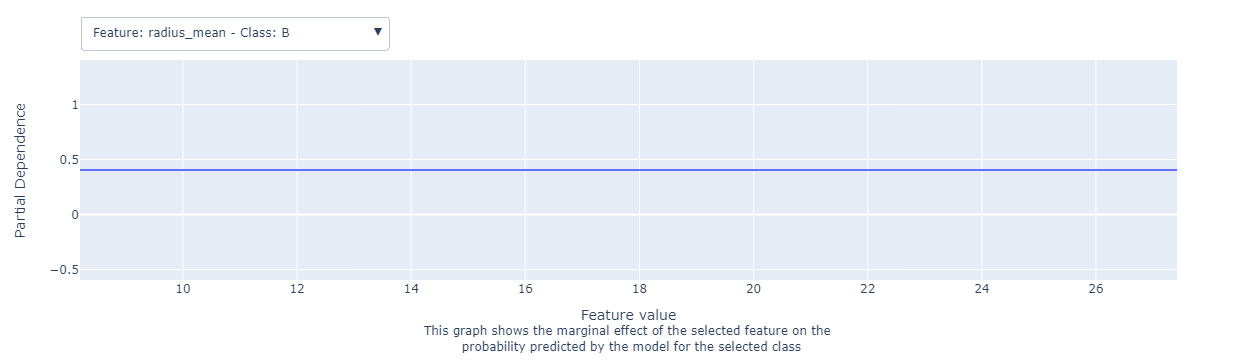

In [13]:
parameters = {
        "grid_resolution": 15,
        "lower_percentile": 0.05,
        "upper_percentile": 0.95,
    }
explainer = PartialDependence(model, **parameters)
explanation = explainer.explain(cc_dataset)
plot = explainer.plot(explanation)
plotly.io.from_json(plot[0])

In [15]:
explanation['area_worst']

{'grid_values': [307.56,
  430.975,
  554.39,
  677.805,
  801.22,
  924.635,
  1048.05,
  1171.465,
  1294.88,
  1418.295,
  1541.71,
  1665.125,
  1788.54,
  1911.955,
  2035.37],
 'average': [[0.019,
   0.03,
   0.064,
   0.173,
   0.459,
   0.805,
   0.954,
   0.989,
   0.998,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0]]}

In [ ]:
for idx in range(len(cc_inputs_columns)):
    pd = partial_dependence(
        estimator=model,
        X=cc_dataset[0]["test"].to_pandas(),
        features=idx,
        feature_names=cc_inputs_columns,
        percentiles=(0.05, 0.95),
        grid_resolution=15,
        kind="average"
    )
    print(cc_inputs_columns[idx])
    print(pd)

/home/naabarca/rod/lib/python3.8/site-packages/sklearn/inspection/_plot/partial_dependence.py:972: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



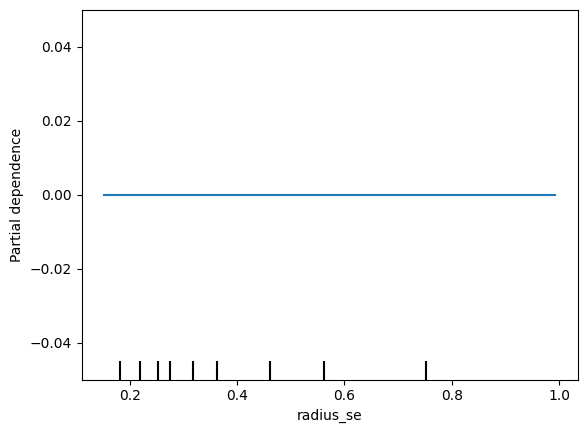

In [9]:
display = PartialDependenceDisplay.from_estimator(
    estimator=model, 
    X=cc_dataset[0]["test"].to_pandas(), 
    features=[10], 
    # target=None, 
    kind='average',
    grid_resolution=15,
    percentiles=(0.05, 0.95)
)

### PFI

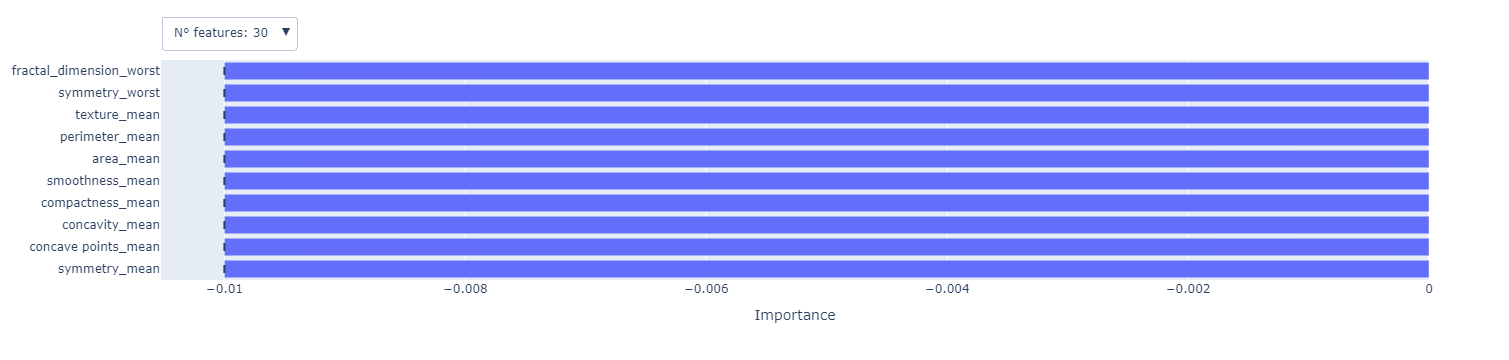

In [16]:
parameters = {
    "scoring": "accuracy",
    "n_repeats": 20,
    "random_state": 5,
    "max_samples": 20,
}
explainer = PermutationFeatureImportance(model, **parameters)
explanation = explainer.explain(cc_dataset)
plot = explainer.plot(explanation)
plotly.io.from_json(plot[0])

<BarContainer object of 30 artists>

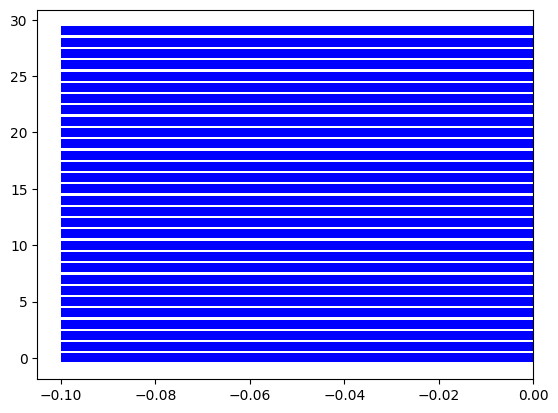

In [10]:
def patched_metric(y_true, y_pred_probas):
    return accuracy_score(y_true, np.argmax(y_pred_probas, axis=1))

pi = permutation_importance(
    estimator=model, 
    X=cc_dataset[0]["train"].to_pandas(), 
    y=cc_dataset[1]["train"].to_pandas(), 
    scoring=make_scorer(patched_metric),
    n_repeats=20,
    random_state=5,
    max_samples=20
)
plt.barh(range(30), pi['importances_mean'], color='b', align='center')

### SHAP

In [11]:
parameters = {
        "link": "identity",
    }
fit_parameters = {
    "sample_background_data": True,
    "n_background_samples": 50,
    "sampling_method": "kmeans",
}

explainer = KernelShap(model, **parameters)
explainer.fit(background_dataset=cc_dataset, **fit_parameters)
explanation = explainer.explain_instance(cc_dataset_i[0])
plots = explainer.plot(explanation)
plotly.io.from_json(plots[0])

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


In [12]:
instances = cc_dataset_i[0]
splits = list(instances.keys())
X = instances[splits[0]]
for split in splits[1:]:
    X = concatenate_datasets([X, instances[split]])

X = X.to_pandas()
kernel_shap = shap.KernelExplainer(
    model=model.predict_proba,
    data=cc_dataset[0]["train"].to_pandas(),
    feature_names=cc_inputs_columns,
    link='identity'
)

shap_values = kernel_shap.shap_values(X)

Using 350 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


In [13]:
instance = 9
y_pred = model.predict_proba(X)
print(f"expected_values: {kernel_shap.expected_value}")
print(f"prediction row {instance}: {y_pred[instance]}")

expected_values: [0.28571429 0.71428571]
prediction row 9: [0.28571429 0.71428571]


IndexError: index 27 is out of bounds for axis 0 with size 10

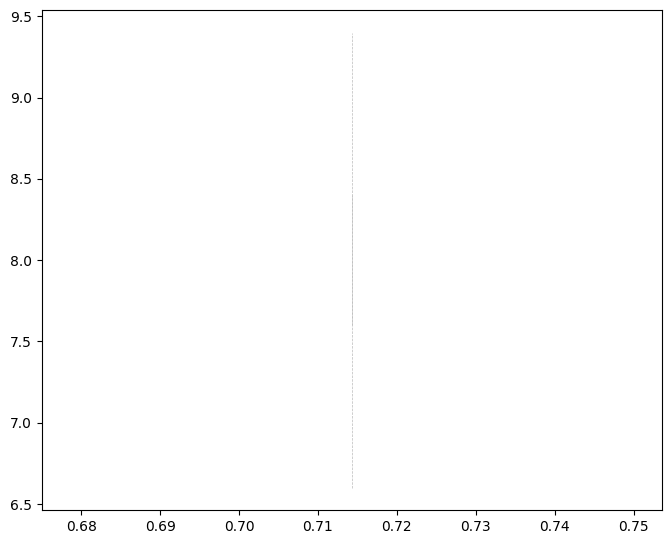

In [14]:
clase = 1
explanation_shap = shap.Explanation(values=shap_values[clase][instance], 
           base_values=kernel_shap.expected_value[clase], 
           data=X.values,
           feature_names=cc_inputs_columns)
shap.plots.waterfall(explanation_shap)